In [3]:
import sys
sys.path.append('/home/npopkov/dll24')

import h5py
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
torch.set_float32_matmul_precision('medium')

class LatentDataset(Dataset):
    def __init__(self, h5_file):
        self.shape = np.array(h5_file[list(h5_file.keys())[0]]).shape
        self.data = self.createData(h5_file)
        self.min = self.data.min()
        self.max = self.data.max()
        self.std = self.data.std()
        self.mean = self.data.mean()
        self.transform('normalize')


    def createData(self, h5_file):
        data = []
        for key in h5_file.keys():
        
            sample = np.array(h5_file[key])
            sample = np.pad(sample, [(0, 0)] * (sample.ndim - 1) + [(0, 1)], mode='constant')
            
            data.append(np.array(sample))
        
        return torch.tensor(np.array(data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    def transform(self, type: str = 'normalize'):
        if type == 'standardize':
            self.data = (self.data - self.mean) / self.std
        elif type == 'normalize':
            self.data = (self.data - self.min) / (self.max - self.min)
        else:
            raise ValueError('Unknown transformation type')
        
    def inverse_transform(self, data):

        return data * (self.max - self.min) + self.min
    
    def unflatten(self, data):
        return data.reshape(self.shape)
    

hdf = h5py.File('encoded_samples.hdf5', 'r')
dataset = LatentDataset(hdf)
hdf.close()

In [4]:
dataset.data.shape

torch.Size([3395, 256, 104])

In [4]:
# from models.ddpm.DDPMBase import DDPMBase
# from models.ddpm.CAUnet import CAUnet
# from models.ddpm.oneDCAUnet import oneDCAUnet


# n_steps, betaMin, betaMax = 200, 10**-6, 0.002

# #network = CAUnet(n_steps=n_steps,
# #                 c_in=256,
# #                 c_out=256,).to('cuda')

# #model = DDPMBase(network=network,
# #                betaMin=betaMin,
# #                betaMax=betaMax,
# #                n_steps=n_steps).to('cuda')


/home/npopkov/dll24/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler
# fac = 4
# model = DiffusionModel(
#     net_t=UNetV0, # The model type used for diffusion (U-Net V0 in this case)
#     in_channels=256, # U-Net: number of input/output (audio) channels
#     channels=[fac*8, fac*32, fac*64, fac*128, fac*256, fac*512, fac*512, fac*1024, fac*1024], # U-Net: channels at each layer
#     factors=[1, 4, 4, 4, 2, 2, 2, 2, 2], # U-Net: downsampling and upsampling factors at each layer
#     items=[1, 2, 2, 2, 2, 2, 2, 4, 4], # U-Net: number of repeating items at each layer
#     attentions=[1,1,1, 1, 1, 1, 1, 1, 1], # U-Net: attention enabled/disabled at each layer
#     attention_heads=16, # U-Net: number of attention heads per attention item
#     attention_features=64, # U-Net: number of attention features per attention item
#     diffusion_t=VDiffusion, # The diffusion method used
#     sampler_t=VSampler, # The diffusion sampler used
# )

In [6]:
import torch
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D

model = Unet1D(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 256
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 104,
    timesteps = 1000,
    objective = 'pred_v'
)

# Or using trainer

trainer = Trainer1D(
    diffusion,
    dataset = dataset,
    train_batch_size = 64,
    train_lr = 8e-5,
    train_num_steps = 7000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
)
trainer.train()

# after a lot of training

sampled_seq = diffusion.sample(batch_size = 4)
sampled_seq.shape 


loss: 0.3030: 100%|██████████| 7000/7000 [10:54<00:00, 10.70it/s]


training complete


sampling loop time step: 100%|██████████| 1000/1000 [00:07<00:00, 138.22it/s]


torch.Size([4, 256, 104])

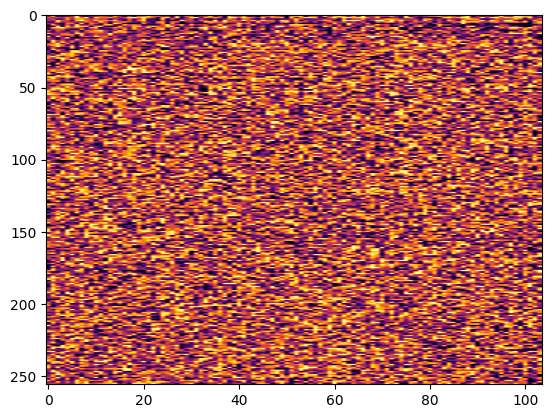

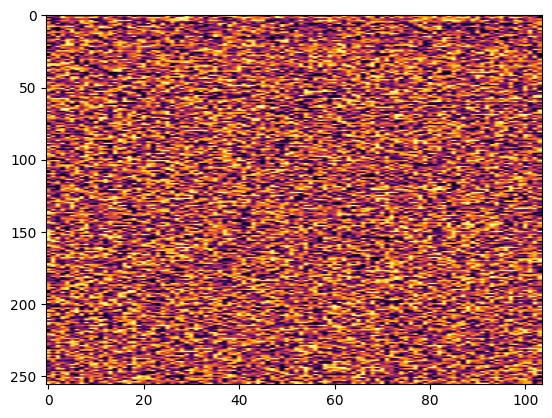

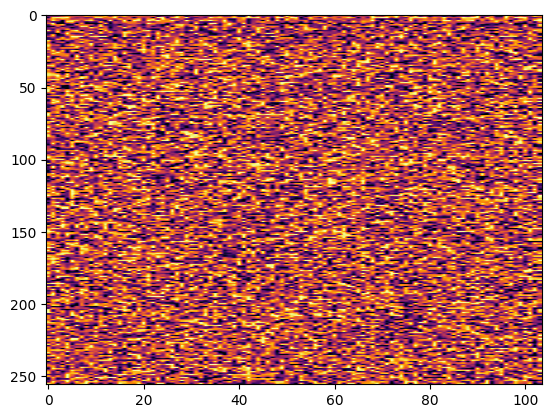

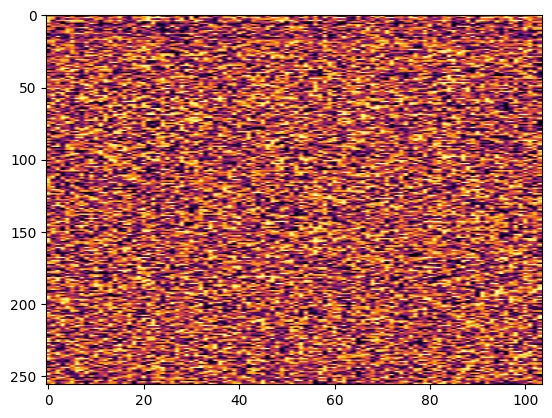

In [9]:
for i in range(4):
    plt.imshow(sampled_seq[i].detach().cpu().numpy(), aspect='auto', cmap='inferno',)
    plt.show()

In [7]:
import lightning as lt

class Lightningwrapper(lt.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        loss = self.model(batch)
        self.log('train_loss', loss)
        return loss
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=3e-4)

lt_model = Lightningwrapper(model)
dataloader = DataLoader(dataset, batch_size=64,num_workers=30,shuffle=True,)
# Train model with audio waveforms
trainer = lt.Trainer(max_epochs=100)
trainer.fit(lt_model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | DiffusionModel | 2.6 B  | train
-------------------------------------------------
2.6 B     Trainable params
0         Non-trainable params
2.6 B     Total params
10,281.845Total estimated model params size (MB)
1586      Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|          | 0/54 [00:00<?, ?it/s] 

RuntimeError: Calculated padded input size per channel: (1). Kernel size: (2). Kernel size can't be greater than actual input size